<a href="https://colab.research.google.com/github/Nilufayeasmin299/Covid19-twitter-data-analysis-using-80-20-sploting-techniques/blob/main/SA_with_300d_80_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

In [ ]:
#Read csv file
df=pd.read_csv('/content/gdrive/My Drive/project for paper /dataset/tencities_15days_april.csv')
df.head()

,twitteDate,tweet_id,created_at,text,loc,user_id,verified,CleanedText,Subjectivity,Polarity,Analysis
0,2020-04-01,1245138809454395392,2020-04-01 00:00:00+00:00,thebsimone during corona stay clean fuck free ...,CA,u282394,0,thebsimon corona stay clean fuck free manit ki...,0.733333,-0.005556,Negative
1,2020-04-01,1245138809920126983,2020-04-01 00:00:00+00:00,balance joining fight against corona turning s...,CA,u460114,0,balanc join fight corona turn shoe product med...,0.000000,0.000000,Neutral
2,2020-04-01,1245138828622471168,2020-04-01 00:00:04+00:00,tory lanez asked young thug been staying coron...,WA,u127769,0,tori lanez ask young thug stay coronafre respo...,0.400000,0.100000,Positive
3,2020-04-01,1245138837057216518,2020-04-01 00:00:06+00:00,hasanthehun donald trump already trying spin c...,FL,u457103,0,hasanthehun donald trump alreadi tri spin coro...,0.000000,0.000000,Neutral
4,2020-04-01,1245138844766416896,2020-04-01 00:00:08+00:00,ghastly corona found into life affected family...,TX,u616396,0,ghast corona found life affect famili lost ano...,0.000000,0.000000,Neutral



**Let's now see the distribution of sentiments across all the tweets**

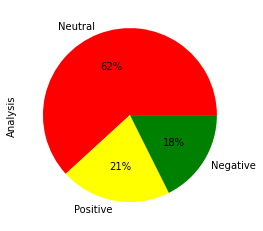

In [ ]:
df.Analysis.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

In [ ]:
df.columns

Index(['twitteDate', 'tweet_id', 'created_at', 'text', 'loc', 'user_id',
       'verified', 'CleanedText', 'Subjectivity', 'Polarity', 'Analysis'],
      dtype='object')

**We will perform only sentiment analysis so we drop all columns except Cleanedtext and Analysis columns**

In [ ]:
data=df.drop(['twitteDate','tweet_id','created_at','text','loc','user_id','verified','Subjectivity','Polarity'],axis=1)

In [ ]:
data.head()

,CleanedText,Analysis
0,thebsimon corona stay clean fuck free manit ki...,Negative
1,balanc join fight corona turn shoe product med...,Neutral
2,tori lanez ask young thug stay coronafre respo...,Positive
3,hasanthehun donald trump alreadi tri spin coro...,Neutral
4,ghast corona found life affect famili lost ano...,Neutral


In [ ]:
data.shape

(823002, 2)

In [ ]:
#importing all necessary libraries 
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.layers.core import Dense, Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras import regularizers
from keras.preprocessing.sequence import pad_sequences

In [ ]:
#Here we make our X value which will then be fitted to scikit learning training test split model
X= data['CleanedText'].values
X.shape

(823002,)

In [ ]:
# Creat the function to get label of the dataset
def getSentiment(Analysis):
    if Analysis== 'Negative':
        return 0
    elif Analysis == 'Positive':
        return 1
    else:
      return 2
data['Sentiment']=data['Analysis'].apply(getSentiment)

In [ ]:
data.head()

,CleanedText,Analysis,Sentiment
0,thebsimon corona stay clean fuck free manit ki...,Negative,0
1,balanc join fight corona turn shoe product med...,Neutral,2
2,tori lanez ask young thug stay coronafre respo...,Positive,1
3,hasanthehun donald trump alreadi tri spin coro...,Neutral,2
4,ghast corona found life affect famili lost ano...,Neutral,2


In [ ]:
y= data['Sentiment'].values
y.shape

(823002,)

In [ ]:
# spliting the dataset into train and test


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(658401,) (164601,) (658401,) (164601,)


**Preparing the Embedding Layer**

In [ ]:
from keras.preprocessing.text import Tokenizer
# we will use the 'Tokenizer' class from the 'keras.preprocessing.text' module to create a word-to-index dictionary.
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 500

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
embeddings_dictionary = dict()
glove_file = open('/content/gdrive/My Drive/project for paper /dataset/glove.6B.300d.txt', encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

**Bulid LTSM model for text classification**

In [ ]:
num_labels = 3
from keras.layers import LSTM
#Defining LTSM model:
model = Sequential()
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(LSTM(50))
model.add(Dense(num_labels, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          109565100 
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                70200     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153       
Total params: 109,635,453
Trainable params: 70,353
Non-trainable params: 109,565,100
_________________________________________________________________


In [ ]:
BATCH_SIZE = 128

**Fit LTSM model**

In [ ]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=1, validation_split=0.2)

4115/4115 [==============================] - 3546s 861ms/step - loss: 0.9332 - acc: 0.6166 - val_loss: 0.9303 - val_acc: 0.6174


In [ ]:
y_pred=model.predict(X_test)

In [ ]:
from sklearn import metrics
score = metrics.log_loss(y_test, y_pred)
print("Log loss score: {}".format(score))

Log loss score: 0.9273054022143595


In [ ]:
import numpy as np
y_pred = np.argmax(y_pred,axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     28850
           1       0.00      0.00      0.00     33672
           2       0.62      1.00      0.77    102079

    accuracy                           0.62    164601
   macro avg       0.21      0.33      0.26    164601
weighted avg       0.38      0.62      0.47    164601



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Build CNN model for sentiment analysis**

In [ ]:
#Defining CNN model
model = Sequential()

embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(num_labels, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 300)          109565100 
_________________________________________________________________
conv1d (Conv1D)              (None, 496, 128)          192128    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 109,757,615
Trainable params: 192,515
Non-trainable params: 109,565,100
_________________________________________________________________


**Fit CNN model**

In [ ]:
#Let's now train our model:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=2, validation_split=0.2)

Epoch 1/2
4115/4115 [==============================] - 4687s 1s/step - loss: 0.2420 - acc: 0.9185 - val_loss: 0.0713 - val_acc: 0.9834
Epoch 2/2
4115/4115 [==============================] - 4685s 1s/step - loss: 0.0520 - acc: 0.9884 - val_loss: 0.0637 - val_acc: 0.9856


In [ ]:
y_pred=model.predict(X_test)

In [ ]:
from sklearn import metrics
score = metrics.log_loss(y_test, y_pred)
print("Log loss score: {}".format(score))

Log loss score: 0.0621934305867885


In [ ]:
import numpy as np
y_pred = np.argmax(y_pred,axis=1) 

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97     28850
           1       0.98      0.98      0.98     33672
           2       0.99      1.00      0.99    102079

    accuracy                           0.99    164601
   macro avg       0.99      0.98      0.98    164601
weighted avg       0.99      0.99      0.99    164601

